# Ideas

### Data
- **pseulolabeling**: 
1. labels are given only for middle image in sequence: let's try to predict labels for the rest of the sequence by using some kind of simple optical flow predicting (x, y) shift between frames
2. if at some point there will be overfitted model, let's try to use it to predict labels for the rest of the train sequence (in-folds pseudo-labeling), alternatively it could be done out-of-folds
- **label as weighted mean of individual labels**: there is individual labelers output for each record, labels are calculated as 50% vote of labelers: let's use some Bayesian approach to obtain soft labels for each record (~ GT is 50% vote of labelers, labeler's reliability is intersection of its output and GT or something like that)
- **expand data**: 
1. if additional augmentations are needed, copy-pasting positive / mixup aug could be a good idea
2. there is many records with empty labels, let's try to use them as negative examples (e. g. add positive areas from other records to empty records)
- **soft copy-paste positive areas aug**: similarly to mixup, but only positive areas are copied and weights is ~ 1 in the center of the area and ~ 0 on the border
- **stratify by empty / not empty mask**

### Experiments
- **initial gird search for hyperparameters**: learning rate, batch size, optimizer, loss function, model tier, etc.
- **log gradient norms**: to select optimal clipping value

### Environment
- **cache dump**: dump cache on disk with `datasets.py` and dataset args hash as filename

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
import torch
import torch.nn.functional as F
import networkx as nx
import numpy as np
import json
import pandas as pd
import yaml
from collections import defaultdict
from scipy.spatial import KDTree
from sklearn.model_selection import StratifiedGroupKFold
from copy import deepcopy
from typing import Dict
from pathlib import Path
from tqdm import tqdm
from scipy.ndimage import distance_transform_edt
from skimage import segmentation as skimage_seg

from src.data.datasets import ContrailsDataset, BANDS
from src.data.datamodules import ContrailsDatamodule
from src.utils.utils import temp_seed

In [4]:
def calculate_is_mask_empty(record_dirs):
    dataset = ContrailsDataset(
        record_dirs=record_dirs, 
        shared_cache=None,
        transform=None,
        transform_mix=None,
        transform_cpp=None,
        is_mask_empty=None,

        band_ids=[],
        mask_type='voting50',
        mmap=True,
        conversion_type='ash',
        quantize=True,
        stats_precomputed=False,
    )
    is_mask_empty = []
    for item in dataset:
        is_mask_empty.append(item['mask'].sum() == 0)
    return is_mask_empty

### Single record visualization

In [2]:
BASE_DIR = '/workspace/data/train'
record_id = '1704010292581573769'

In [3]:
data = {}
for band in range(8, 17):
    data[band] = np.load(os.path.join(BASE_DIR, record_id, f'band_{band:02}.npy'))

In [4]:
data[8].min((0, 1)), data[8].max((0, 1))

(array([217.03496, 216.71512, 216.64188, 216.58307, 217.03197, 217.49298,
        217.72519, 216.18779], dtype=float32),
 array([236.81677, 236.72633, 236.79573, 237.0424 , 237.27965, 237.38416,
        237.42242, 237.44275], dtype=float32))

In [5]:
labels = np.load(os.path.join(BASE_DIR, record_id, 'human_pixel_masks.npy'))
labels.shape

(256, 256, 1)

In [6]:
individual_labels = np.load(os.path.join(BASE_DIR, record_id, 'human_individual_masks.npy'))
individual_labels.shape

(256, 256, 1, 4)

### Animation

In [ ]:
plt.close('all')

fig, axes = plt.subplots(3, 3, dpi=90, figsize=(5, 5))
fig.suptitle(f'Record {record_id}')

ims = []
for band, ax in zip(data, axes.flat):
    im = ax.imshow(data[band][:, :, 0], animated=True)
    ax.set_title(f'Band {band:02}')
    ims.append(im)
i = 0

def updatefig(*args):
    global ims, i
    for band, im in zip(data, ims):
        im.set_array(data[band][:, :, i])
    i = (i + 1) % 8
    return ims

# remove axes and spacing
for ax in axes.flat:
    ax.set_axis_off()

fig.subplots_adjust(hspace=0, wspace=0)
fig.tight_layout()

ani = animation.FuncAnimation(fig, updatefig, interval=50, blit=True, repeat=True)

# writer = animation.ImageMagickFileWriter()
# ani.save('./animation.gif', writer=writer)


### Mean, std, min, max, quantiles

Full, single time index

In [2]:
record_dirs = []
for data_dir in [Path('/workspace/data/train'), Path('/workspace/data/validation')]:
    record_dirs += [path for path in data_dir.iterdir() if path.is_dir()]
dataset = ContrailsDataset(
    record_dirs=record_dirs, 
    band_ids=BANDS,
    mask_type='voting50',
    propagate_mask=False,
    mmap=True,
    transform=None,
)

In [24]:
def calc_stats(dataset):
    # mean, std, min, max across all images
    min_, max_ = float('inf'), float('-inf')
    sums, sums_sq, ns = [], [], []
    for item in tqdm(dataset):
        image = item['image']
        sums.append(image.sum())
        sums_sq.append((image ** 2).sum())
        ns.append(np.prod(image.shape))
        min_ = min(min_, image.min())
        max_ = max(max_, image.max())
    mean = sum(sums) / sum(ns)

    sum_sq = 0
    for sum_, sum_sq_, n in zip(sums, sums_sq, ns):
        sum_sq += (sum_sq_ - 2 * sum_ * mean + mean ** 2 * n)
    std = np.sqrt(sum_sq / sum(ns))

    return mean, std, min_, max_

In [25]:
mean, std, min_, max_ = calc_stats(dataset)
mean, std, min_, max_

100%|██████████| 22385/22385 [16:22<00:00, 22.79it/s]


(260.1077976678496, 21.99711806156345, 178.84055, 336.71628)

In [5]:
def histogram(dataset, min_, max_, bins=256):
    # histogram of pixel values
    hist = np.zeros(bins, dtype=np.uint64)
    for item in tqdm(dataset):
        image = item['image']
        hist += np.histogram(image, bins=bins, range=(min_, max_), density=False)[0].astype(np.uint64)
    bins = np.linspace(min_, max_, bins)
    return hist, bins

In [7]:
min_, max_ = 178.84055, 336.71628
hist, bins = histogram(dataset, min_, max_, bins=256)

100%|██████████| 22385/22385 [19:02<00:00, 19.59it/s]


(array([2.90185500e+06, 9.92071520e+07, 5.70444257e+08, 2.47555910e+09,
        3.13785945e+09, 2.77101581e+09, 2.61239484e+09, 1.49118157e+09,
        4.25049050e+07, 1.41307000e+05]),
 array([178.84055 , 194.628123, 210.415696, 226.203269, 241.990842,
        257.778415, 273.565988, 289.353561, 305.141134, 320.928707,
        336.71628 ]),
 <BarContainer object of 10 artists>)

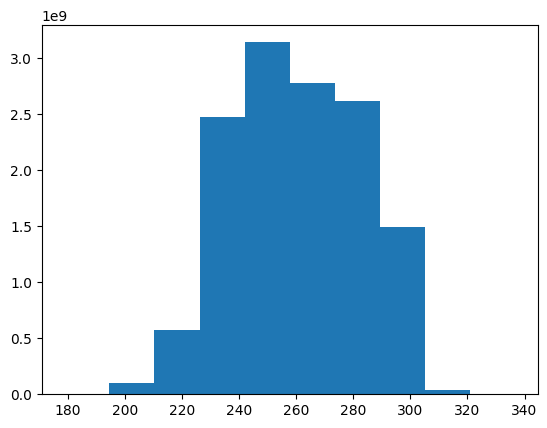

In [8]:
val, weight = zip(*[(k, v) for k,v in zip(bins, hist)])
plt.hist(val, weights=weight)

In [9]:
hist_density = hist / hist.sum()
qs = np.arange(1, 20) / 20
# first occurence of cumulative sum >= q ~ quantile
quantiles = bins[(np.cumsum(hist_density)[:, None] >= qs[None, :]).argmax(axis=0)]
quantiles

array([225.89370875, 232.08491384, 235.7996369 , 238.89523945,
       242.60996251, 245.70556506, 249.42028812, 252.51589067,
       256.23061373, 259.32621627, 263.04093933, 267.3747829 ,
       271.08950596, 274.18510851, 279.13807259, 283.47191616,
       287.18663922, 290.28224176, 293.37784431])

In [10]:
quantiles_dict = {q: q_ for q, q_ in zip(qs, quantiles)}
quantiles_dict

{0.05: 225.89370874509805,
 0.1: 232.08491384313726,
 0.15: 235.79963690196078,
 0.2: 238.8952394509804,
 0.25: 242.60996250980392,
 0.3: 245.70556505882354,
 0.35: 249.42028811764706,
 0.4: 252.51589066666668,
 0.45: 256.23061372549023,
 0.5: 259.3262162745098,
 0.55: 263.0409393333333,
 0.6: 267.37478290196077,
 0.65: 271.0895059607843,
 0.7: 274.1851085098039,
 0.75: 279.1380725882353,
 0.8: 283.47191615686273,
 0.85: 287.1866392156863,
 0.9: 290.2822417647059,
 0.95: 293.3778443137255}

In [11]:
hist_dict = {k: v for k, v in zip(bins, hist)}
hist_dict

{178.84055: 8,
 179.45967050980394: 10,
 180.07879101960785: 21,
 180.69791152941178: 40,
 181.3170320392157: 107,
 181.93615254901962: 222,
 182.55527305882353: 484,
 183.17439356862747: 1106,
 183.79351407843137: 2074,
 184.4126345882353: 3687,
 185.0317550980392: 6214,
 185.65087560784315: 8921,
 186.26999611764705: 13206,
 186.889116627451: 18495,
 187.50823713725492: 26920,
 188.12735764705883: 37452,
 188.74647815686276: 53783,
 189.36559866666667: 73714,
 189.9847191764706: 100841,
 190.6038396862745: 136533,
 191.22296019607845: 184309,
 191.84208070588235: 247158,
 192.4612012156863: 326065,
 193.0803217254902: 426149,
 193.69944223529413: 552589,
 194.31856274509803: 681747,
 194.93768325490197: 824624,
 195.55680376470588: 984588,
 196.1759242745098: 1152364,
 196.79504478431375: 1324257,
 197.41416529411765: 1537067,
 198.0332858039216: 1742189,
 198.6524063137255: 1982076,
 199.27152682352943: 2223597,
 199.89064733333333: 2509276,
 200.50976784313727: 2771390,
 201.128888

Stats [from histogram](https://stackoverflow.com/questions/50786699/how-to-calculate-the-standard-deviation-from-a-histogram-python-matplotlib) as self-check

In [15]:
mids = 0.5*(bins[1:] + bins[:-1])
mean = np.average(mids, weights=hist[:-1])
var = np.average((mids - mean)**2, weights=hist[:-1])
std = np.sqrt(var)
mean, std

(260.4264655384578, 22.084094376561833)

Class weights

In [3]:
record_dirs = []
for data_dir in [Path('/workspace/data/train'), Path('/workspace/data/validation')]:
    record_dirs += [path for path in data_dir.iterdir() if path.is_dir()]
dataset = ContrailsDataset(
    record_dirs=record_dirs, 
    band_ids=[],
    mask_type='voting50',
    propagate_mask=False,
    mmap=True,
    transform=None,
)

In [4]:
def histogram(dataset):
    # histogram of pixel values
    n_pos, n_total = 0, 0
    for item in tqdm(dataset):
        n_pos += item['mask'].sum()
        n_total += np.prod(item['mask'].shape)
    return n_pos, n_total

In [5]:
n_pos, n_total = histogram(dataset)
n_pos, n_total

100%|██████████| 22385/22385 [16:45<00:00, 22.26it/s]


(7399663.0, 1467023360)

In [6]:
n_neg = n_total - n_pos
n_neg, n_pos

(1459623697.0, 7399663.0)

In [10]:
n_pos / n_neg, n_neg / n_pos

(0.005069568968501064, 197.25542865938624)

Hist of n positive per record

In [5]:
def n_positives(dataset):
    n_pos = []
    for item in tqdm(dataset):
        n_pos.append(item['mask'].sum())
    return n_pos

In [6]:
n_pos_all = n_positives(dataset)

100%|██████████| 22385/22385 [00:24<00:00, 925.15it/s] 


(array([1.4428e+04, 1.5390e+03, 1.0290e+03, 7.7900e+02, 5.6900e+02,
        5.0700e+02, 4.3600e+02, 3.3800e+02, 2.8500e+02, 2.5800e+02,
        2.1900e+02, 2.0400e+02, 1.8400e+02, 1.6000e+02, 1.4700e+02,
        1.2100e+02, 1.1100e+02, 8.5000e+01, 8.1000e+01, 8.7000e+01,
        8.8000e+01, 6.8000e+01, 6.0000e+01, 5.5000e+01, 5.5000e+01,
        5.1000e+01, 4.9000e+01, 3.7000e+01, 3.0000e+01, 2.2000e+01,
        3.4000e+01, 1.9000e+01, 2.0000e+01, 2.7000e+01, 1.7000e+01,
        1.3000e+01, 1.2000e+01, 1.1000e+01, 1.0000e+01, 9.0000e+00,
        8.0000e+00, 9.0000e+00, 1.1000e+01, 8.0000e+00, 5.0000e+00,
        1.0000e+01, 6.0000e+00, 5.0000e+00, 3.0000e+00, 4.0000e+00,
        1.0000e+00, 7.0000e+00, 4.0000e+00, 2.0000e+00, 2.0000e+00,
        3.0000e+00, 5.0000e+00, 4.0000e+00, 4.0000e+00, 0.0000e+00,
        2.0000e+00, 2.0000e+00, 1.0000e+00, 4.0000e+00, 1.0000e+00,
        2.0000e+00, 0.0000e+00, 2.0000e+00, 1.0000e+00, 2.0000e+00,
        3.0000e+00, 1.0000e+00, 0.0000e+00, 1.00

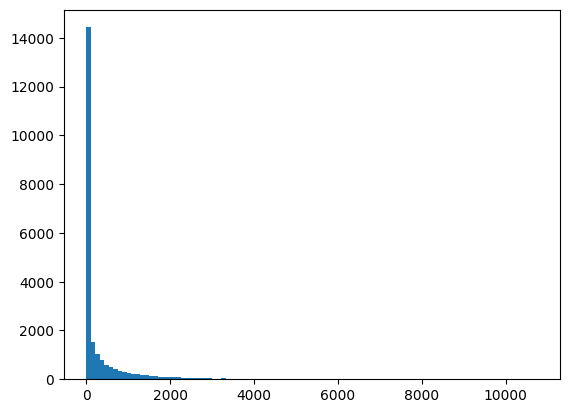

In [7]:
plt.hist(n_pos_all, bins=100)

In [8]:
len([n for n in n_pos_all if n == 0]), len([n for n in n_pos_all if n > 0])

(12574, 9811)

### Labels vs frame alignment

In [ ]:
import sys
sys.path.insert(0, '/workspace/contrails/lib/unimatch')
from utils.frame_utils import read_gen
from unimatch.unimatch import UniMatch

No alignment

In [ ]:
plt.close('all')

fig, axes = plt.subplots(2, 4, dpi=90, figsize=(8, 4))
fig.suptitle(f'Record {record_id}')

for frame_index, ax in zip(range(8), axes.flat):
    ax.imshow(data[8][:, :, frame_index])
    ax.imshow(labels, alpha=0.5, cmap='gray')
    ax.set_title(f'Frame {frame_index}')

# remove axes and spacing
for ax in axes.flat:
    ax.set_axis_off()

fig.subplots_adjust(hspace=0, wspace=0)
fig.tight_layout()

Optical flow

In [ ]:
 
prev_gray = data[8][:, :, 0]

# Creates an image filled with zero
# intensities with the same dimensions 
# as the frame
mask = np.zeros((*data[8].shape[:2], 3), dtype=np.uint8)

# Sets image saturation to maximum
mask[..., 1] = 255

for frame_index in range(1, data[8].shape[2]):
    frame = data[8][:, :, frame_index]

    # Opens a new window and displays the input
    # frame
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    ax = axes[0]
    ax.imshow(frame, cmap='gray')
      
    # Converts each frame to grayscale - we previously 
    # only converted the first frame to grayscale
    gray = frame
      
    # Calculates dense optical flow by Farneback method
    flow = cv.calcOpticalFlowFarneback(prev_gray, gray, 
                                       None,
                                       0.5, 3, 15, 3, 5, 1.2, 0)
      
    # Computes the magnitude and angle of the 2D vectors
    magnitude, angle = cv.cartToPolar(flow[..., 0], flow[..., 1])
      
    # Sets image hue according to the optical flow 
    # direction
    mask[..., 0] = angle * 180 / np.pi / 2
      
    # Sets image value according to the optical flow
    # magnitude (normalized)
    mask[..., 2] = cv.normalize(magnitude, None, 0, 255, cv.NORM_MINMAX)
      
    # Converts HSV to RGB (BGR) color representation
    rgb = cv.cvtColor(mask, cv.COLOR_HSV2BGR)
      
    # Opens a new window and displays the output frame
    ax = axes[1]
    ax.imshow(rgb, cmap='gray')
      
    # Updates previous frame
    prev_gray = gray

Convolution

In [ ]:
from scipy.signal import convolve2d

In [ ]:
labels[:, :, 0] > 0

In [ ]:
mask = labels[:, :, 0] > 0
trails = np.zeros_like(data[8][:, :, 4])
trails[mask] = data[8][:, :, 4][mask]

conv = convolve2d(data[8][:, :, 0], trails, mode='same')
print(np.unravel_index(conv.argmax(), conv.shape))
conv = convolve2d(trails, data[8][:, :,-1], mode='same')
print(np.unravel_index(conv.argmax(), conv.shape))

In [ ]:
plt.imshow(mask, cmap='gray')

In [ ]:
plt.close('all')

In [ ]:
data[8][:, :, 4].min()

In [ ]:
trails.min(), trails.max()

In [ ]:
plt.figure()
plt.imshow(trails, vmin=217.03197, vmax=235.95107)
plt.show()

In [ ]:
prev_frame = data[8][:, :, 0]
conv = convolve2d(data[8][:, :, 0], data[8][:, :, 4], mode='same')
print(np.unravel_index(conv.argmax(), conv.shape))
conv = convolve2d(data[8][:, :, 4], data[8][:, :,-1], mode='same')
print(np.unravel_index(conv.argmax(), conv.shape))
conv = convolve2d(data[8][:, :, 0], data[8][:, :,-1], mode='same')
print(np.unravel_index(conv.argmax(), conv.shape))

Unimatch

In [271]:
feature_channels = 128
num_scales = 2
upsample_factor = 4
num_head = 1
ffn_dim_expansion = 4
num_transformer_layers = 6
attn_splits_list = [2, 8]
corr_radius_list = [-1, 4]
prop_radius_list = [-1, 1]
reg_refine = True
num_reg_refine = 6
task = 'flow'
attn_type = 'swin'
pred_bidir_flow = False
padding_factor = 32
device = 'cuda'
fixed_inference_size = None
resume = '/workspace/contrails/lib/unimatch/pretrained/gmflow-scale2-regrefine6-mixdata-train320x576-4e7b215d.pth'

In [272]:
model = UniMatch(
    feature_channels=feature_channels,
    num_scales=num_scales,
    upsample_factor=upsample_factor,
    num_head=num_head,
    ffn_dim_expansion=ffn_dim_expansion,
    num_transformer_layers=num_transformer_layers,
    reg_refine=reg_refine,
    task=task
).to(device)
checkpoint = torch.load(resume, map_location=device)
model.load_state_dict(checkpoint['model'], strict=True)

<All keys matched successfully>

In [273]:
# https://www.kaggle.com/code/inversion/visualizing-contrails
_T11_BOUNDS = (243, 303)
_CLOUD_TOP_TDIFF_BOUNDS = (-4, 5)
_TDIFF_BOUNDS = (-4, 2)
N_TIMES_BEFORE = 4

def normalize_range(data, bounds):
    """Maps data to the range [0, 1]."""
    return (data - bounds[0]) / (bounds[1] - bounds[0])

def get_color_images(data, type_='false', mult=1.0):
    band11 = data[11]
    band14 = data[14]
    band15 = data[15]
    if type_ == 'false':
        r = normalize_range(band15 - band14, _TDIFF_BOUNDS)
        g = normalize_range(band14 - band11, _CLOUD_TOP_TDIFF_BOUNDS)
        b = normalize_range(band14, _T11_BOUNDS)
        colored = np.clip(np.stack([r, g, b], axis=2), 0, 1) * mult
    elif type_ == 'minmax3':
        r = (band11 - band11.min()) / (band11.max() - band11.min())
        g = (band14 - band14.min()) / (band14.max() - band14.min())
        b = (band15 - band15.min()) / (band15.max() - band15.min())
        colored = np.stack([r, g, b], axis=2) * mult
    elif type_ == 'minmax1':
        r = g = b = (band11 - band11.min()) / (band11.max() - band11.min())
        colored = np.stack([r, g, b], axis=2) * mult
    return colored

In [274]:
color_images = get_color_images(data, type_='false', mult=255)

In [275]:
color_images.shape

(256, 256, 3, 8)

In [276]:
color_images

array([[[[  0.        ,   0.        ,   0.        , ...,  50.029068  ,
           58.48484   ,  25.939293  ],
         [205.82565   , 216.97983   , 169.52097   , ...,  93.70112   ,
           78.20892   ,  62.1093    ],
         [208.01472   , 214.77364   , 196.40906   , ...,  10.728695  ,
            0.        ,  53.867336  ]],

        [[  0.        ,   0.        ,   0.        , ...,  37.4255    ,
           68.723335  ,  34.417763  ],
         [198.95157   , 215.83588   , 176.9986    , ...,  86.27322   ,
          106.316574  ,  62.976128  ],
         [203.36914   , 214.63927   , 200.75569   , ...,  21.43171   ,
            0.        ,  35.368916  ]],

        [[  0.        ,   0.        ,   0.        , ...,  23.228569  ,
           64.326515  ,  54.244957  ],
         [190.1683    , 213.8584    , 194.58328   , ...,  68.72528   ,
          120.63413   ,  67.187904  ],
         [194.32362   , 213.20401   , 209.09526   , ...,  31.006596  ,
            0.        ,  18.281822  ]],

    

In [277]:
color_images.min(), color_images.max()

(0.0, 255.0)

In [325]:
data[8].shape

(256, 256, 8)

In [533]:
from typing import Dict
from scipy.ndimage import geometric_transform


@torch.no_grad()
def calculate_flow(image1, image2, pred_bwd_flow=False):
    transpose_img = False

    image1 = torch.from_numpy(image1).float().permute(2, 0, 1).unsqueeze(0).to(device)
    image2 = torch.from_numpy(image2).float().permute(2, 0, 1).unsqueeze(0).to(device)

    # the model is trained with size: width > height
    if image1.size(-2) > image1.size(-1):
        image1 = torch.transpose(image1, -2, -1)
        image2 = torch.transpose(image2, -2, -1)
        transpose_img = True

    nearest_size = [int(np.ceil(image1.size(-2) / padding_factor)) * padding_factor,
                    int(np.ceil(image1.size(-1) / padding_factor)) * padding_factor]

    # resize to nearest size or specified size
    inference_size = nearest_size if fixed_inference_size is None else fixed_inference_size

    assert isinstance(inference_size, list) or isinstance(inference_size, tuple)
    ori_size = image1.shape[-2:]

    # resize before inference
    if inference_size[0] != ori_size[0] or inference_size[1] != ori_size[1]:
        image1 = F.interpolate(image1, size=inference_size, mode='bilinear',
                                align_corners=True)
        image2 = F.interpolate(image2, size=inference_size, mode='bilinear',
                                align_corners=True)
    
    if pred_bwd_flow:
        image1, image2 = image2, image1

    results_dict = model(
        image1, 
        image2,
        attn_type=attn_type,
        attn_splits_list=attn_splits_list,
        corr_radius_list=corr_radius_list,
        prop_radius_list=prop_radius_list,
        num_reg_refine=num_reg_refine,
        task='flow',
        pred_bidir_flow=pred_bidir_flow,
    )
    flow_pr = results_dict['flow_preds'][-1]  # [B, 2, H, W]

    # resize back
    if inference_size[0] != ori_size[0] or inference_size[1] != ori_size[1]:
        flow_pr = F.interpolate(flow_pr, size=ori_size, mode='bilinear',
                                align_corners=True)
        flow_pr[:, 0] = flow_pr[:, 0] * ori_size[-1] / inference_size[-1]
        flow_pr[:, 1] = flow_pr[:, 1] * ori_size[-2] / inference_size[-2]

    if transpose_img:
        flow_pr = torch.transpose(flow_pr, -2, -1)

    flow = flow_pr[0].permute(1, 2, 0).cpu().numpy()  # [H, W, 2]

    return flow


def get_flow_images_cum(data, labels_time_index, wrt='next', color_type='false', mult=1.0):
    color_images = get_color_images(data, type_=color_type, mult=mult)

    if wrt == 'next':
        flow_images = []
        for i in range(1, color_images.shape[-1]):
            flow = calculate_flow(
                color_images[..., i - 1], 
                color_images[..., i],
                pred_bwd_flow=i < labels_time_index
            )
            flow_images.append(flow)
        
        flow_images = np.stack(flow_images, axis=0)

        # Get cumulative flow images forward and back 
        # w.r.t. labels_time_index
        #
        # Example:
        # 0 1 2 3 4 5 6 7 -- frame indices
        #         ^ labels_time_index
        #  0 1 2 3 4 5 6 -- flow image indices
        # 0 1 2 3 -- flow images back
        # 4 5 6 -- flow images forward
        # 0 1 2 3 x 4 5 6 -- flow images total
        flow_images_cum_back = np.cumsum(flow_images[:labels_time_index][::-1], axis=0)[::-1]
        flow_images_cum_current = np.zeros_like(flow_images_cum_back[0])[None, ...]
        flow_images_cum_forward = np.cumsum(flow_images[labels_time_index:], axis=0)
        flow_images_cum = np.concatenate(
            (
                flow_images_cum_back, 
                flow_images_cum_current, 
                flow_images_cum_forward
            ), 
            axis=0
        )
    elif wrt == 'labeled':
        flow_images_cum = []
        for i in range(color_images.shape[-1]):
            if i == labels_time_index:
                flow = np.zeros((*color_images.shape[:2], 2))
            else:
                flow = calculate_flow(
                    color_images[..., i - 1], 
                    color_images[..., i],
                    pred_bwd_flow=i < labels_time_index
                )
            flow_images_cum.append(flow)
        flow_images_cum = np.stack(flow_images_cum, axis=0)
    else:
        raise ValueError(f'wrt must be either "next" or "labeled", got {wrt}')
    
    return flow_images_cum


def pseudolabel_by_flows(
    data: Dict[int, np.ndarray], 
    labels: np.ndarray, 
    labels_time_index: int = N_TIMES_BEFORE,
):
    """Generate pseudolabels for each frame except labels_time_index.
    data: dict of band data, where each band data is of shape (H, W, T)
    """
    # Get cumulative flow images
    flow_images = get_flow_images_cum(
        data, 
        labels_time_index, 
        wrt='next',
        color_type='minmax3', 
        mult=255
    )

    # Get pseudolabels for each frame except labels_time_index
    pseudolabels = []
    for i in range(flow_images.shape[0]):
        if i == labels_time_index:
            pseudolabels.append(labels)
        else:
            # TODO: see if C extension is needed to speed up
            # def mapping(coords):
            #     h, w = coords
            #     return (h + flow_images_cum[i, h, w, 0], h + flow_images_cum[i, h, w, 1])
                
            def mapping(coords):
                x, y = coords
                return (x + flow_images[i, y, x, 0], y + flow_images[i, y, x, 1])
            
            labels_mapped = geometric_transform(
                labels[..., 0], 
                mapping, 
                order=2,
                output_shape=labels.shape[:2],
            )[..., None]
            pseudolabels.append(labels_mapped)
        
    return np.concatenate(pseudolabels, axis=-1), flow_images

In [534]:
pseudolabels, flow_images = pseudolabel_by_flows(data, labels, labels_time_index=N_TIMES_BEFORE)

In [535]:
pseudolabels.shape, flow_images.shape

((256, 256, 8), (8, 256, 256, 2))

In [536]:
flow_images.min(), flow_images.max()

(-32.240143, 31.55515)

In [537]:
color_images.min(), color_images.max()

(0.0, 255.0)

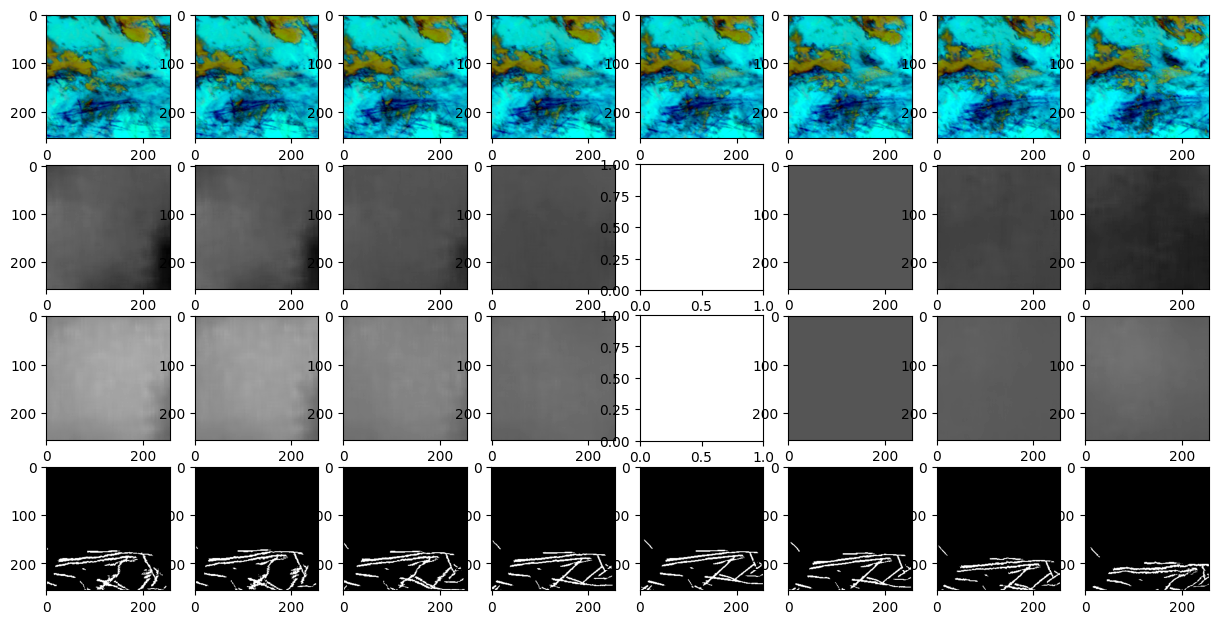

In [538]:
fig, axes = plt.subplots(4, 8, figsize=(15, 7.5))

for i in range(axes.shape[1]):
    axes[0, i].imshow(color_images[..., i].astype(np.uint8))
    if i != N_TIMES_BEFORE:
        axes[1, i].imshow(flow_images[i - (i > N_TIMES_BEFORE), ..., 0], cmap='gray', vmin=-30, vmax=60)
        axes[2, i].imshow(flow_images[i - (i > N_TIMES_BEFORE), ..., 1], cmap='gray', vmin=-30, vmax=60)
    axes[3, i].imshow(pseudolabels[..., i], cmap='gray')

In [311]:
image1.shape

torch.Size([1, 3, 256, 256])

In [312]:
image1_mapped = geometric_transform(
    color_images[..., 0, 0],
    mapping,
    order=1,
    output_shape=image1.shape[-2:],
)
labels_mapped = geometric_transform(
    labels[:, :, 0], 
    mapping, 
    order=1,
    output_shape=labels.shape[:2],
)

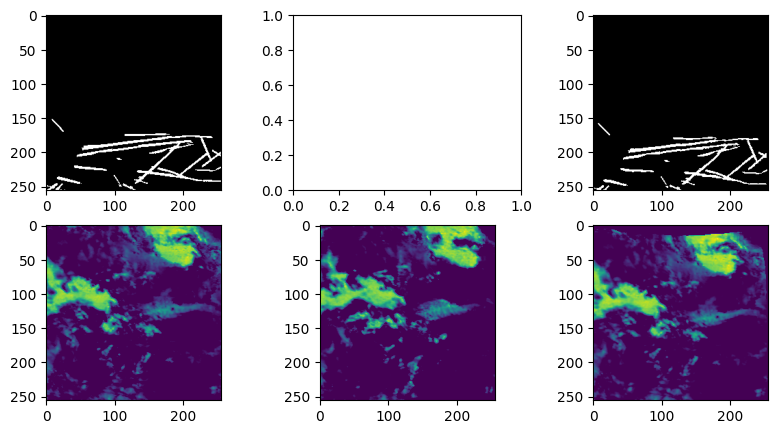

In [313]:
fig, axes = plt.subplots(2, 3, figsize=(10, 5))
ax = axes[0, 0]
ax.imshow(labels[:, :, 0], cmap='gray')
ax = axes[0, 2]
ax.imshow(labels_mapped, cmap='gray')
ax = axes[1, 0]
ax.imshow(color_images[..., 0, 0])
ax = axes[1, 1]
ax.imshow(color_images[..., 0, 4])
ax = axes[1, 2]
ax.imshow(image1_mapped)

### Copy-paste positive

In [49]:
record_dirs = []
for data_dir in [Path('/workspace/data/train'), Path('/workspace/data/validation')]:
    record_dirs += [path for path in data_dir.iterdir() if path.is_dir()]

is_mask_empty = calculate_is_mask_empty(record_dirs)
empty_mask_indices = [i for i, v in enumerate(is_mask_empty) if v]
nonempty_mask_indices = [i for i, v in enumerate(is_mask_empty) if not v]

dataset = ContrailsDataset(
    record_dirs=record_dirs, 
    shared_cache=None,
    transform=None,
    transform_mix=None,
    transform_cpp=None,
    is_mask_empty=None,

    band_ids=BANDS,
    mask_type='voting50',
    handle_time='single+mean',
    mmap=True,
    conversion_type='ash',
    quantize=True,
    stats_precomputed=False,
)

In [353]:
class CopyPastePositive:
    """Copy area masked by mask1 from image1 to image
    and from mask1 to mask.

    Targets:
        image, mask

    Image types:
        uint8, float32
    """

    def __init__(
        self, 
        mask_positive_value: int = 255,
        always_apply=True,
        p=1.0, 
    ):
        self.mask_positive_value = mask_positive_value
        self.always_apply = always_apply
        self.p = p

    def __call__(self, *args, force_apply: bool = False, **kwargs) -> Dict[str, np.ndarray]:
        # Toss a coin
        if not force_apply and not self.always_apply and random.random() > self.p:
            return kwargs

        # mask = \
        #     np.isclose(kwargs['mask'], self.mask_positive_value) & \
        #     (~np.isclose(kwargs['mask1'], self.mask_positive_value))
        mask = np.isclose(kwargs['mask1'], self.mask_positive_value)

        # Use smooth mask as weight between input and output areas:
        # - blure mask
        # - get edges as dilation \ erosion
        # - mask[edge] = blured_mask[edge]
        # - mask[erosion] = 1
        # - mask[~dilation] = 0
        inner_mask = cv2.erode(mask.astype(np.uint8), (9, 9), iterations=1) > 0
        blur_mask = cv2.GaussianBlur(inner_mask.astype(np.float32), (9, 9), sigmaX=5, sigmaY=5)
        outer_mask = cv2.dilate(mask.astype(np.uint8), (9, 9), iterations=1) > 0
        edge_mask = outer_mask & (~inner_mask)
        smooth_mask = inner_mask.astype(np.float32)
        smooth_mask[edge_mask] = blur_mask[edge_mask]
        # smooth_mask[inner_mask] = 1
        # smooth_mask[~outer_mask] = 0
        smooth_mask = smooth_mask[..., None]
        print(smooth_mask.min(), smooth_mask.max())

        kwargs['image1'] = kwargs['image1'] - \
            kwargs['image_mean1'].mean((0, 1), where=~mask[..., None]) +\
            kwargs['image_mean'].mean((0, 1), where=~mask[..., None])
        
        kwargs['smooth_mask'] = smooth_mask
        kwargs['image'] = (kwargs['image1'] * smooth_mask + kwargs['image'] * (1 - smooth_mask)).astype(kwargs['image'].dtype)
        kwargs['mask'][mask] = kwargs['mask1'][mask]

        return kwargs

In [354]:
transform_cpp = CopyPastePositive(mask_positive_value=255, always_apply=True, p=1.0)

In [355]:
item_empty_mask = dataset._get_item_cached(empty_mask_indices[0])
item_nonempty_mask = dataset._get_item_cached(nonempty_mask_indices[0])

# # same image but rotated
# item_empty_mask = dataset._get_item_cached(nonempty_mask_indices[0])
# item_empty_mask['image'] = np.rot90(item_empty_mask['image'], k=1, axes=(0, 1))
# item_empty_mask['mask'] = np.rot90(item_empty_mask['mask'], k=1, axes=(0, 1))
# item_empty_mask['image_mean'] = np.rot90(item_empty_mask['image_mean'], k=1, axes=(0, 1))
# item_nonempty_mask = dataset._get_item_cached(nonempty_mask_indices[0])

In [356]:
item_empty_mask['image'].shape, item_empty_mask['mask'].shape

((256, 256, 3), (256, 256))

In [357]:
item_nonempty_mask['mask'].min(), item_nonempty_mask['mask'].max()

(0, 255)

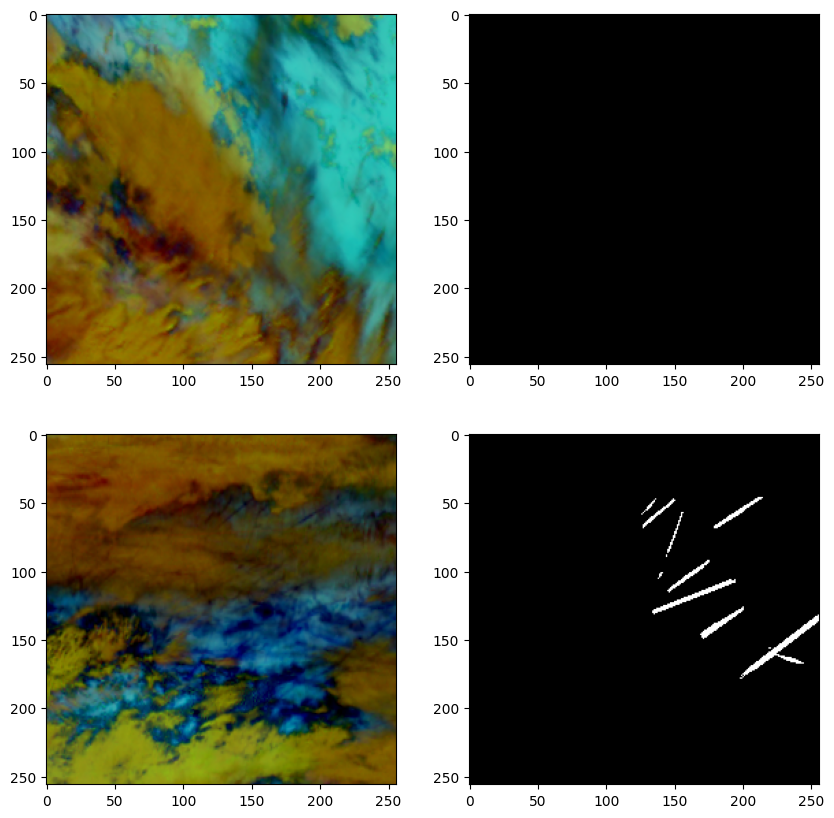

In [358]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

ax = axes[0, 0]
ax.imshow(item_empty_mask['image'])

ax = axes[0, 1]
ax.imshow(item_empty_mask['mask'], cmap='gray')

ax = axes[1, 0]
ax.imshow(item_nonempty_mask['image'])

ax = axes[1, 1]
ax.imshow(item_nonempty_mask['mask'], cmap='gray')

In [359]:
item_empty_mask_populated = transform_cpp(
    **deepcopy(item_empty_mask), 
    **{f'{k}1': v for k, v in deepcopy(item_nonempty_mask).items()}
)

0.0 1.0


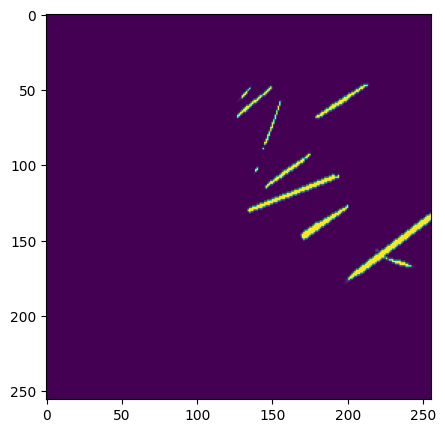

In [360]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(item_empty_mask_populated['smooth_mask'])

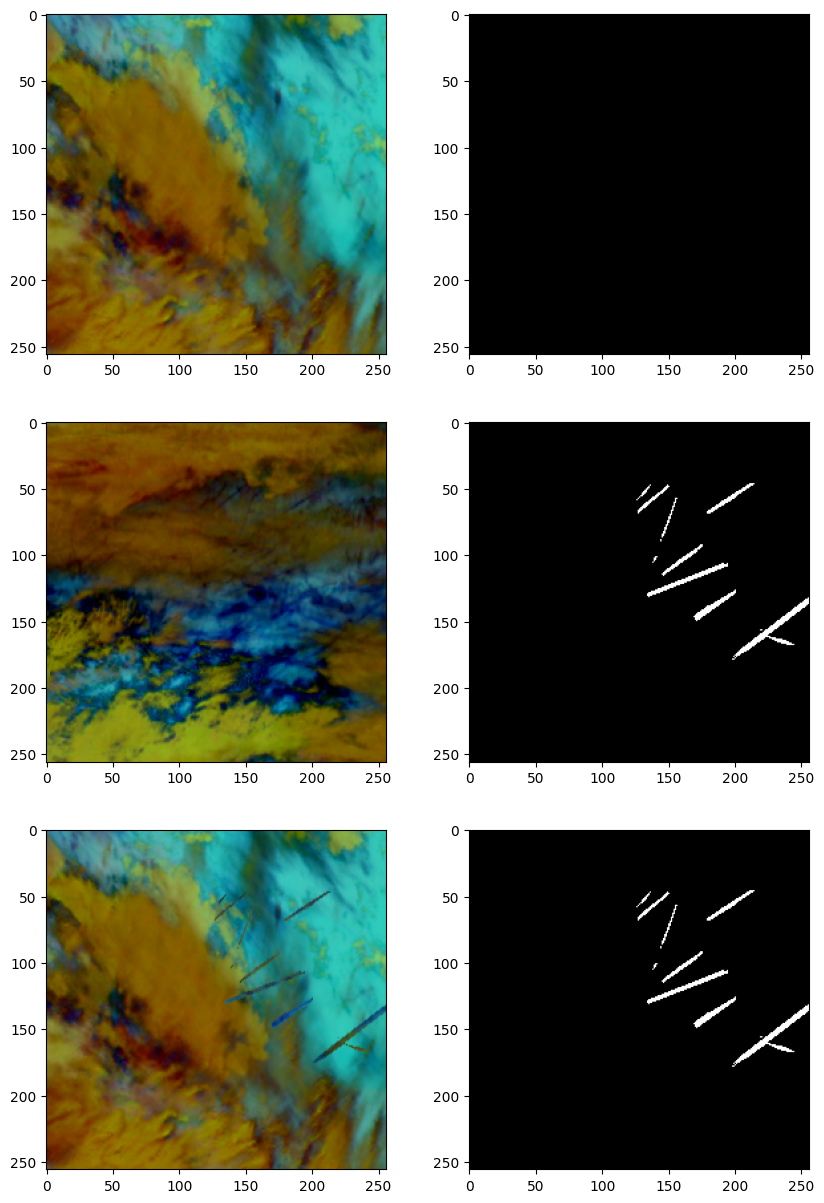

In [361]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

ax = axes[0, 0]
ax.imshow(item_empty_mask['image'])

ax = axes[0, 1]
ax.imshow(item_empty_mask['mask'], cmap='gray')

ax = axes[1, 0]
ax.imshow(item_nonempty_mask['image'])

ax = axes[1, 1]
ax.imshow(item_nonempty_mask['mask'], cmap='gray')

ax = axes[2, 0]
ax.imshow(item_empty_mask_populated['image'])

ax = axes[2, 1]
ax.imshow(item_empty_mask_populated['mask'], cmap='gray')

### Better ash color scheme fitting

In [7]:
def calculate_board_contrast(image, mask):
    """Calculate contrast between area inside mask and area outside mask."""
    # Get area outside mask as difference between dilated mask and mask
    mask_dilated = cv2.dilate(mask.astype(np.uint8), (9, 9), iterations=1) > 0
    mask_outside = mask_dilated & (~mask)
    # Get area inside mask
    mask_inside = mask
    # Convert to torch tensors
    image = torch.from_numpy(image).float()
    mask_outside = torch.from_numpy(mask_outside).bool()
    # Calculate mean values for each area
    mean_outside = image[mask_outside].mean()
    mean_inside = image[mask_inside].mean()
    # Calculate contrast
    contrast = mean_inside - mean_outside
    return contrast

: 

In [3]:
_T11_BOUNDS = (243, 303)  # -> 
_CLOUD_TOP_TDIFF_BOUNDS = (-4, 5)
_TDIFF_BOUNDS = (-4, 2)

In [4]:
def convert_bounds(bounds):
    return 1 / (bounds[1] - bounds[0]), - bounds[0] / (bounds[1] - bounds[0])

In [5]:
convert_bounds(_T11_BOUNDS), convert_bounds(_CLOUD_TOP_TDIFF_BOUNDS), convert_bounds(_TDIFF_BOUNDS)

((0.016666666666666666, -4.05),
 (0.1111111111111111, 0.4444444444444444),
 (0.16666666666666666, 0.6666666666666666))

In [ ]:
def get_ash(data):
    band11 = data[11]
    band14 = data[14]
    band15 = data[15]
    r = normalize_range(band15 - band14, _TDIFF_BOUNDS)
    g = normalize_range(band14 - band11, _CLOUD_TOP_TDIFF_BOUNDS)
    b = normalize_range(band14, _T11_BOUNDS)
    images = np.stack([r, g, b], axis=2) * 255.0
        
    return images

### Grouping by spatial (or spatio-temporal) similarity

In [3]:
with open('/workspace/data/train_metadata.json', 'r') as f:
    train_metadata = json.load(f)
with open('/workspace/data/validation_metadata.json', 'r') as f:
    validation_metadata = json.load(f)

df = pd.DataFrame(train_metadata + validation_metadata)
df

,record_id,projection_wkt,row_min,row_size,col_min,col_size,timestamp
0,3283699311323360356,"PROJCS[""unknown"",GEOGCS[""unknown"",DATUM[""WGS_1...",1686563.50,-1960.975830,371650.93750,1947.130737,1.571009e+09
1,8563667897034605935,"PROJCS[""unknown"",GEOGCS[""unknown"",DATUM[""WGS_1...",3182392.75,-1977.611084,360291.81250,1938.791138,1.566377e+09
2,6375533009500587038,"PROJCS[""unknown"",GEOGCS[""unknown"",DATUM[""WGS_1...",2702499.50,-2035.440063,830456.93750,1890.603882,1.570222e+09
3,3029407526724839139,"PROJCS[""unknown"",GEOGCS[""unknown"",DATUM[""WGS_1...",2689881.50,-1998.106812,565498.75000,1918.643677,1.570406e+09
4,4486503791474809647,"PROJCS[""unknown"",GEOGCS[""unknown"",DATUM[""WGS_1...",4179394.25,-2073.804688,736862.00000,1853.664795,1.572367e+09
...,...,...,...,...,...,...,...
22380,1399093805695992618,"PROJCS[""unknown"",GEOGCS[""unknown"",DATUM[""WGS_1...",4196753.00,-2050.188477,626928.56250,1875.403564,1.571062e+09
22381,3008528739771697013,"PROJCS[""unknown"",GEOGCS[""unknown"",DATUM[""WGS_1...",4696927.50,-2058.764893,592684.56250,1868.726685,1.576930e+09
22382,2179021099259593019,"PROJCS[""unknown"",GEOGCS[""unknown"",DATUM[""WGS_1...",2682475.50,-1966.615967,322780.87500,1946.472900,1.570548e+09
22383,4632924604458483815,"PROJCS[""unknown"",GEOGCS[""unknown"",DATUM[""WGS_1...",4692273.50,-2042.555176,528789.06250,1884.564697,1.563274e+09


In [4]:
def group_neighbors(df, tol, p=np.inf, show=False):
    r = np.linalg.norm(np.ones(len(tol)), p)
    kd = KDTree(df[tol.index] / tol)
    g = nx.Graph([
        (i, j)
        for i, neighbors in enumerate(kd.query_ball_tree(kd, r=r, p=p))
        for j in neighbors
    ])
    if show:
        nx.draw_networkx(g)
    ix, id_ = np.array([
        (j, i)
        for i, s in enumerate(nx.connected_components(g))
        for j in s
    ]).T
    id_[ix] = id_.copy()
    return df.assign(set_id=id_)

In [5]:
cols_to_group = ['row_min', 'row_size', 'col_min', 'col_size']
tol = pd.Series([1e3, 1e2, 1e3, 1e2], index=cols_to_group)
df = group_neighbors(df, tol)
df['set_id_spatial'] = df['set_id']

cols_to_group = ['row_min', 'row_size', 'col_min', 'col_size', 'timestamp']
tol = pd.Series([1e3, 1e2, 1e3, 1e2, 3600], index=cols_to_group)
df = group_neighbors(df, tol)
df['set_id_spatiotemporal'] = df['set_id']

df['set_id_spatial'].nunique(), df['set_id_spatiotemporal'].nunique()

(6154, 21180)

<Axes: >

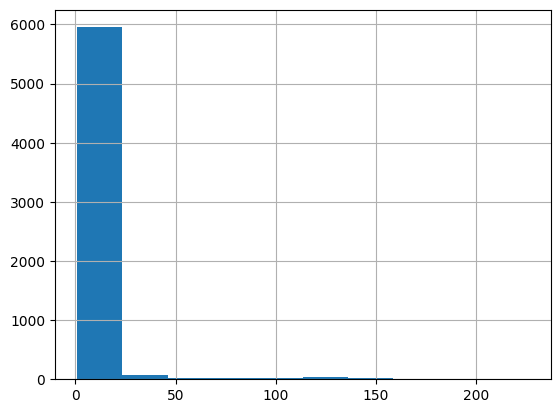

In [6]:
df['set_id_spatial'].value_counts().hist()

<Axes: >

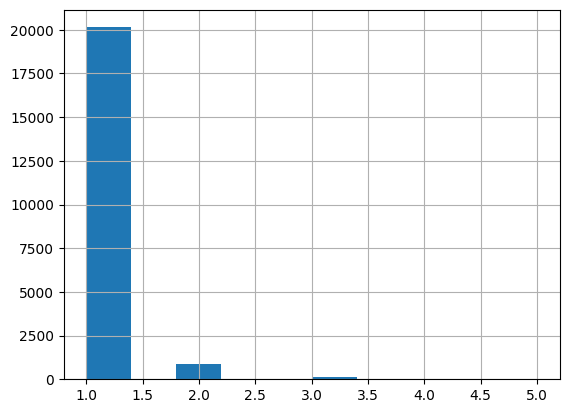

In [7]:
df['set_id_spatiotemporal'].value_counts().hist()

In [8]:
record_dirs = []
for data_dir in [Path('/workspace/data/train'), Path('/workspace/data/validation')]:
    record_dirs += [path for path in data_dir.iterdir() if path.is_dir()]

dataset = ContrailsDataset(
    record_dirs=record_dirs, 
    shared_cache=None,
    transform=None,
    transform_mix=None,
    transform_cpp=None,
    is_mask_empty=None,

    band_ids=[],
    mask_type='voting50',
    mmap=True,
    conversion_type='ash',
    quantize=True,
    stats_precomputed=False,
)

mask_sums, pathes = [], []
for item in dataset:
    mask_sums.append(item['mask'].sum())
    pathes.append(item['path'])

In [4]:
pathes[0]

'/workspace/data/train/859235657188916843'

In [9]:
df_mask_sums = pd.DataFrame({'path': pathes, 'mask_sum': mask_sums})
df_mask_sums['record_id'] = df_mask_sums['path'].str.split('/').str[-1]

In [10]:
df_mask_sums['record_id'].dtype

dtype('O')

In [11]:
df = df.merge(df_mask_sums, on='record_id', how='left')

In [12]:
df

,record_id,projection_wkt,row_min,row_size,col_min,col_size,timestamp,set_id,set_id_spatial,set_id_spatiotemporal,path,mask_sum
0,3283699311323360356,"PROJCS[""unknown"",GEOGCS[""unknown"",DATUM[""WGS_1...",1686563.50,-1960.975830,371650.93750,1947.130737,1.571009e+09,0,0,0,/workspace/data/train/3283699311323360356,0.0
1,8563667897034605935,"PROJCS[""unknown"",GEOGCS[""unknown"",DATUM[""WGS_1...",3182392.75,-1977.611084,360291.81250,1938.791138,1.566377e+09,1,1,1,/workspace/data/train/8563667897034605935,0.0
2,6375533009500587038,"PROJCS[""unknown"",GEOGCS[""unknown"",DATUM[""WGS_1...",2702499.50,-2035.440063,830456.93750,1890.603882,1.570222e+09,2,2,2,/workspace/data/train/6375533009500587038,0.0
3,3029407526724839139,"PROJCS[""unknown"",GEOGCS[""unknown"",DATUM[""WGS_1...",2689881.50,-1998.106812,565498.75000,1918.643677,1.570406e+09,3,3,3,/workspace/data/train/3029407526724839139,0.0
4,4486503791474809647,"PROJCS[""unknown"",GEOGCS[""unknown"",DATUM[""WGS_1...",4179394.25,-2073.804688,736862.00000,1853.664795,1.572367e+09,4,4,4,/workspace/data/train/4486503791474809647,2127.0
...,...,...,...,...,...,...,...,...,...,...,...,...
22380,1399093805695992618,"PROJCS[""unknown"",GEOGCS[""unknown"",DATUM[""WGS_1...",4196753.00,-2050.188477,626928.56250,1875.403564,1.571062e+09,21175,15,21175,/workspace/data/validation/1399093805695992618,0.0
22381,3008528739771697013,"PROJCS[""unknown"",GEOGCS[""unknown"",DATUM[""WGS_1...",4696927.50,-2058.764893,592684.56250,1868.726685,1.576930e+09,21176,423,21176,/workspace/data/validation/3008528739771697013,0.0
22382,2179021099259593019,"PROJCS[""unknown"",GEOGCS[""unknown"",DATUM[""WGS_1...",2682475.50,-1966.615967,322780.87500,1946.472900,1.570548e+09,21177,239,21177,/workspace/data/validation/2179021099259593019,0.0
22383,4632924604458483815,"PROJCS[""unknown"",GEOGCS[""unknown"",DATUM[""WGS_1...",4692273.50,-2042.555176,528789.06250,1884.564697,1.563274e+09,21178,113,21178,/workspace/data/validation/4632924604458483815,75.0


<Axes: >

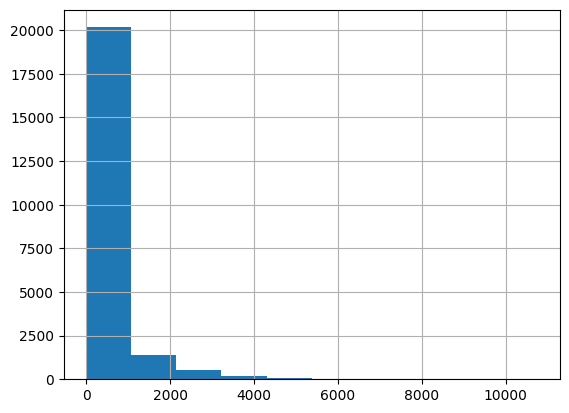

In [13]:
df['mask_sum'].hist() 

In [24]:
# qcut
df['mask_sum_qcut'] = pd.qcut(df['mask_sum'], 10, duplicates='drop')
df['mask_sum_qcut_code'] = df['mask_sum_qcut'].cat.codes
df['mask_sum_g0'] = df['mask_sum'] > 0

In [25]:
df['mask_sum_qcut_code']

0        0
1        0
2        0
3        0
4        4
        ..
22380    0
22381    0
22382    0
22383    1
22384    0
Name: mask_sum_qcut_code, Length: 22385, dtype: int8

In [26]:
df['fold_s_g0'] = -1
df['fold_st_g0'] = -1
df['fold_s_qcut'] = -1
df['fold_st_qcut'] = -1
for fold, (_, test_index) in enumerate(StratifiedGroupKFold(n_splits=5).split(df, df['mask_sum_g0'], df['set_id_spatial'])):
    df.loc[test_index, 'fold_s_g0'] = fold
for fold, (_, test_index) in enumerate(StratifiedGroupKFold(n_splits=5).split(df, df['mask_sum_g0'], df['set_id_spatiotemporal'])):
    df.loc[test_index, 'fold_st_g0'] = fold
for fold, (_, test_index) in enumerate(StratifiedGroupKFold(n_splits=5).split(df, df['mask_sum_qcut_code'], df['set_id_spatial'])):
    df.loc[test_index, 'fold_s_qcut'] = fold
for fold, (_, test_index) in enumerate(StratifiedGroupKFold(n_splits=5).split(df, df['mask_sum_qcut_code'], df['set_id_spatiotemporal'])):
    df.loc[test_index, 'fold_st_qcut'] = fold
df['fold_s_g0'].value_counts(), df['fold_st_g0'].value_counts(), df['fold_s_qcut'].value_counts(), df['fold_st_qcut'].value_counts()

(fold_s_g0
 1    4501
 2    4488
 3    4466
 0    4466
 4    4464
 Name: count, dtype: int64,
 fold_st_g0
 3    4478
 0    4478
 4    4477
 1    4476
 2    4476
 Name: count, dtype: int64,
 fold_s_qcut
 3    4477
 4    4477
 1    4477
 0    4477
 2    4477
 Name: count, dtype: int64,
 fold_st_qcut
 0    4479
 2    4477
 1    4477
 3    4476
 4    4476
 Name: count, dtype: int64)

In [71]:
df

,record_id,projection_wkt,row_min,row_size,col_min,col_size,timestamp,path,is_mask_empty,set_id,set_id_spatial,set_id_spatiotemporal,fold,fold_spatial,fold_spatiotemporal
0,3283699311323360356,"PROJCS[""unknown"",GEOGCS[""unknown"",DATUM[""WGS_1...",1686563.50,-1960.975830,371650.93750,1947.130737,1.571009e+09,/workspace/data/train/3283699311323360356,True,0,0,0,3,3,3
1,8563667897034605935,"PROJCS[""unknown"",GEOGCS[""unknown"",DATUM[""WGS_1...",3182392.75,-1977.611084,360291.81250,1938.791138,1.566377e+09,/workspace/data/train/8563667897034605935,True,1,1,1,1,1,1
2,6375533009500587038,"PROJCS[""unknown"",GEOGCS[""unknown"",DATUM[""WGS_1...",2702499.50,-2035.440063,830456.93750,1890.603882,1.570222e+09,/workspace/data/train/6375533009500587038,True,2,2,2,4,0,4
3,3029407526724839139,"PROJCS[""unknown"",GEOGCS[""unknown"",DATUM[""WGS_1...",2689881.50,-1998.106812,565498.75000,1918.643677,1.570406e+09,/workspace/data/train/3029407526724839139,True,3,3,3,2,0,2
4,4486503791474809647,"PROJCS[""unknown"",GEOGCS[""unknown"",DATUM[""WGS_1...",4179394.25,-2073.804688,736862.00000,1853.664795,1.572367e+09,/workspace/data/train/4486503791474809647,False,4,4,4,2,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22380,1399093805695992618,"PROJCS[""unknown"",GEOGCS[""unknown"",DATUM[""WGS_1...",4196753.00,-2050.188477,626928.56250,1875.403564,1.571062e+09,/workspace/data/validation/1399093805695992618,True,21175,15,21175,4,2,4
22381,3008528739771697013,"PROJCS[""unknown"",GEOGCS[""unknown"",DATUM[""WGS_1...",4696927.50,-2058.764893,592684.56250,1868.726685,1.576930e+09,/workspace/data/validation/3008528739771697013,True,21176,423,21176,1,0,1
22382,2179021099259593019,"PROJCS[""unknown"",GEOGCS[""unknown"",DATUM[""WGS_1...",2682475.50,-1966.615967,322780.87500,1946.472900,1.570548e+09,/workspace/data/validation/2179021099259593019,True,21177,239,21177,2,2,2
22383,4632924604458483815,"PROJCS[""unknown"",GEOGCS[""unknown"",DATUM[""WGS_1...",4692273.50,-2042.555176,528789.06250,1884.564697,1.563274e+09,/workspace/data/validation/4632924604458483815,False,21178,113,21178,0,0,0


In [31]:
df.groupby('fold_s_g0')['mask_sum'].sum(), \
df.groupby('fold_st_g0')['mask_sum'].sum(), \
df.groupby('fold_s_qcut')['mask_sum'].sum(), \
df.groupby('fold_st_qcut')['mask_sum'].sum()

(fold_s_g0
 0    1475079.0
 1    1424474.0
 2    1536233.0
 3    1524926.0
 4    1438951.0
 Name: mask_sum, dtype: float32,
 fold_st_g0
 0    1481371.0
 1    1433170.0
 2    1519732.0
 3    1534138.0
 4    1431252.0
 Name: mask_sum, dtype: float32,
 fold_s_qcut
 0    1479825.0
 1    1422909.0
 2    1491204.0
 3    1515228.0
 4    1490497.0
 Name: mask_sum, dtype: float32,
 fold_st_qcut
 0    1485497.0
 1    1452536.0
 2    1476484.0
 3    1448617.0
 4    1536529.0
 Name: mask_sum, dtype: float32)

In [39]:
df = pd.read_csv('/workspace/contrails/split_info.csv')

In [40]:
df

,record_id,projection_wkt,row_min,row_size,col_min,col_size,timestamp,set_id,set_id_spatial,set_id_spatiotemporal,path,mask_sum,mask_sum_qcut,mask_sum_qcut_code,mask_sum_g0
0,3283699311323360356,"PROJCS[""unknown"",GEOGCS[""unknown"",DATUM[""WGS_1...",1686563.50,-1960.975830,371650.93750,1947.130737,1.571009e+09,0,0,0,/workspace/data/train/3283699311323360356,0.0,"(-0.001, 58.0]",0,False
1,8563667897034605935,"PROJCS[""unknown"",GEOGCS[""unknown"",DATUM[""WGS_1...",3182392.75,-1977.611084,360291.81250,1938.791138,1.566377e+09,1,1,1,/workspace/data/train/8563667897034605935,0.0,"(-0.001, 58.0]",0,False
2,6375533009500587038,"PROJCS[""unknown"",GEOGCS[""unknown"",DATUM[""WGS_1...",2702499.50,-2035.440063,830456.93750,1890.603882,1.570222e+09,2,2,2,/workspace/data/train/6375533009500587038,0.0,"(-0.001, 58.0]",0,False
3,3029407526724839139,"PROJCS[""unknown"",GEOGCS[""unknown"",DATUM[""WGS_1...",2689881.50,-1998.106812,565498.75000,1918.643677,1.570406e+09,3,3,3,/workspace/data/train/3029407526724839139,0.0,"(-0.001, 58.0]",0,False
4,4486503791474809647,"PROJCS[""unknown"",GEOGCS[""unknown"",DATUM[""WGS_1...",4179394.25,-2073.804688,736862.00000,1853.664795,1.572367e+09,4,4,4,/workspace/data/train/4486503791474809647,2127.0,"(1065.0, 10744.0]",4,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22380,1399093805695992618,"PROJCS[""unknown"",GEOGCS[""unknown"",DATUM[""WGS_1...",4196753.00,-2050.188477,626928.56250,1875.403564,1.571062e+09,21175,15,21175,/workspace/data/validation/1399093805695992618,0.0,"(-0.001, 58.0]",0,False
22381,3008528739771697013,"PROJCS[""unknown"",GEOGCS[""unknown"",DATUM[""WGS_1...",4696927.50,-2058.764893,592684.56250,1868.726685,1.576930e+09,21176,423,21176,/workspace/data/validation/3008528739771697013,0.0,"(-0.001, 58.0]",0,False
22382,2179021099259593019,"PROJCS[""unknown"",GEOGCS[""unknown"",DATUM[""WGS_1...",2682475.50,-1966.615967,322780.87500,1946.472900,1.570548e+09,21177,239,21177,/workspace/data/validation/2179021099259593019,0.0,"(-0.001, 58.0]",0,False
22383,4632924604458483815,"PROJCS[""unknown"",GEOGCS[""unknown"",DATUM[""WGS_1...",4692273.50,-2042.555176,528789.06250,1884.564697,1.563274e+09,21178,113,21178,/workspace/data/validation/4632924604458483815,75.0,"(58.0, 187.0]",1,True


In [36]:
df['mask_sum_g0']

0        False
1        False
2        False
3        False
4         True
         ...  
22380    False
22381    False
22382    False
22383     True
22384    False
Name: mask_sum_g0, Length: 22385, dtype: bool

### Weighted masks

In [5]:
# https://github.com/Miltos-90/UNet_Biomedical_Image_Segmentation/blob/main/utils.py#L90
from collections import defaultdict


def _class_weights(mask):
    ''' Create a dictionary containing the classes in a mask,
        and their corresponding weights to balance their occurence
    '''
    
    wc = defaultdict()

    # Grab classes and their corresponding counts
    unique, counts = np.unique(mask, return_counts = True)

    # Convert counts to frequencies
    counts = counts / np.product(mask.shape)

    # Get max. counts
    max_count = max(counts)

    for val, count in zip(unique, counts):
        wc[val] = max_count / count
    
    return wc

def weight_map(mask, w0, sigma, background_class = 0):
    
    # Fix mask datatype (should be unsigned 8 bit)
    if mask.dtype != 'uint8': 
        mask = mask.astype('uint8')
    
    # Weight values to balance classs frequencies
    wc = _class_weights(mask)
    
    # Assign a different label to each connected region of the image
    _, regions = cv2.connectedComponents(mask)
    
    # Get total no. of connected regions in the image and sort them excluding background
    region_ids = sorted(np.unique(regions))
    region_ids = [region_id for region_id in region_ids if region_id != background_class]
        
    if len(region_ids) > 1: # More than one connected regions

        # Initialise distance matrix (dimensions: H x W x no.regions)
        distances = np.zeros((mask.shape[0], mask.shape[1], len(region_ids)))

        # For each region
        for i, region_id in enumerate(region_ids):

            # Mask all pixels belonging to a different region
            m = (regions != region_id).astype(np.uint8)# * 255
        
            # Compute Euclidean distance for all pixels belongind to a different region
            distances[:, :, i] = cv2.distanceTransform(m, distanceType = cv2.DIST_L2, maskSize = 0)

        # Sort distances w.r.t region for every pixel
        distances = np.sort(distances, axis = 2)

        # Grab distance to the border of nearest region
        d1, d2 = distances[:, :, 0], distances[:, :, 1]

        # Compute RHS of weight map and mask background pixels
        w = w0 * np.exp(-1 / (2 * sigma ** 2)  * (d1 + d2) ** 2) * (regions == background_class)

    else: # Only a single region present in the image
        w = np.zeros_like(mask)

    # # Instantiate a matrix to hold class weights
    # wc_x = np.zeros_like(mask)
    
    # # Compute class weights for each pixel class (background, etc.)
    # for pixel_class, weight in wc.items():
    
    #     wc_x[mask == pixel_class] = weight
    
    # Add them to the weight map
    w = w + 0
    
    return w

# https://github.com/JunMa11/SegWithDistMap/blob/master/code/utils/losses.py
def compute_sdf01(posmask):
    """
    compute the signed distance map of binary mask
    input: segmentation, shape = (batch_size, class, x, y, z)
    output: the Signed Distance Map (SDM) 
    sdm(x) = 0; x in segmentation boundary
             -inf|x-y|; x in segmentation
             +inf|x-y|; x out of segmentation

    """
    # print(type(segmentation), segmentation.shape)

    posdis = distance_transform_edt(posmask)
    negdis = distance_transform_edt(1 - posmask)
    boundary = skimage_seg.find_boundaries(posmask, mode='inner').astype(np.uint8)
    sdf = negdis/np.max(negdis)/2 - posdis/np.max(posdis)/2 + 0.5
    sdf[boundary>0] = 0.5
    return sdf


def compute_sdf1_1(posmask):
    """
    compute the signed distance map of binary mask
    input: segmentation, shape = (batch_size, class, x, y, z)
    output: the Signed Distance Map (SDM) 
    sdm(x) = 0; x in segmentation boundary
             -inf|x-y|; x in segmentation
             +inf|x-y|; x out of segmentation

    """
    negmask = 1 - posmask
    boundary = skimage_seg.find_boundaries(posmask, mode='inner').astype(np.uint8)
    posdis = distance_transform_edt(posmask)
    negdis = distance_transform_edt(negmask)
    print(posdis.min(), posdis.max(), negdis.min(), negdis.max())
    sdf = np.zeros_like(posmask, dtype=np.float32)
    sdf[posmask > 0] = -posdis[posmask > 0] / np.max(posdis[posmask > 0])
    sdf[negmask > 0] = negdis[negmask > 0] / np.max(negdis[negmask > 0])
    sdf[boundary > 0] = 0
    return sdf

In [6]:
record_dirs = []
for data_dir in [Path('/workspace/data/train'), Path('/workspace/data/validation')]:
    record_dirs += [path for path in data_dir.iterdir() if path.is_dir()]

dataset = ContrailsDataset(
    record_dirs=record_dirs, 
    shared_cache=None,
    transform=None,
    transform_mix=None,
    transform_cpp=None,
    is_mask_empty=None,

    band_ids=BANDS,
    mask_type='voting50',
    propagate_mask=False,
    mmap=True,
    conversion_type='ash',
    quantize=True,
    stats_precomputed=False,
)

In [9]:
dataset[0].keys()

dict_keys(['image', 'masks', 'path'])

In [10]:
compute_sdf1_1(dataset[0]['masks'][0]).min(), compute_sdf01(dataset[0]['masks'][0]).max()

0.0 2.8284271247461903 0.0 183.25119372053214


(-1.0, 1.0)

In [13]:
weight_map(dataset[0]['masks'][0], w0=10, sigma=5).min(), \
weight_map(dataset[0]['masks'][0], w0=10, sigma=5).max()

(0.0, 8.899690962640381)

0.0 2.8284271247461903 0.0 183.25119372053214


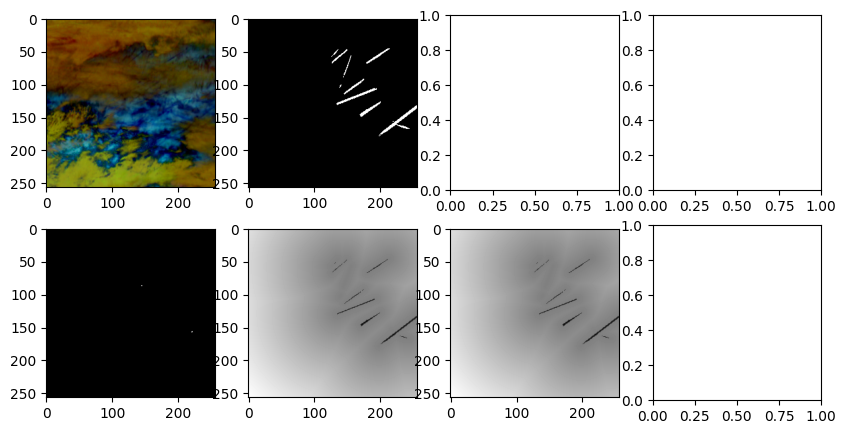

: 

In [14]:
fig, axes = plt.subplots(2, 4, figsize=(10, 5))
axes[0, 0].imshow(dataset[0]['image'])
axes[0, 1].imshow(dataset[0]['masks'][0], cmap='gray')
axes[1, 0].imshow(weight_map(dataset[0]['masks'][0], w0=10, sigma=0.1), cmap='gray')
axes[1, 1].imshow(compute_sdf01(dataset[0]['masks'][0]), cmap='gray')
axes[1, 2].imshow(compute_sdf1_1(dataset[0]['masks'][0]), cmap='gray')

### Error analysis

In [5]:
with open('/workspace/contrails/run/configs/common.yaml', 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
config['data']

{'class_path': 'src.data.datamodules.ContrailsDatamodule',
 'init_args': {'data_dirs': ['../data/train', '../data/validation'],
  'data_dirs_test': None,
  'num_folds': 5,
  'fold_index': 0,
  'img_size': 256,
  'random_state': 0,
  'randaugment_num_ops': 3,
  'randaugment_magnitude': 9,
  'dataset_kwargs': {'band_ids': [11, 14, 15],
   'mask_type': 'weighted',
   'propagate_mask': False,
   'mmap': True,
   'conversion_type': 'ash',
   'quantize': True,
   'stats_precomputed': False},
  'cache_dir': 'cache',
  'split_info_path': './split_info.csv',
  'empty_mask_strategy': None,
  'mix_transform_name': None,
  'batch_size': 16,
  'num_workers': 8,
  'pin_memory': True,
  'prefetch_factor': 1,
  'persistent_workers': True}}

In [19]:
config['data']['init_args']['data_dirs'] = None
config['data']['init_args']['data_dirs_test'] = [Path('../data/validation/')]
config['data']['init_args']['cache_dir'] = None
config['data']['init_args']['dataset_kwargs']['band_ids'] = []

In [24]:
datamodule = ContrailsDatamodule(**config['data']['init_args'])
datamodule.setup()
datamodule.test_dataset.transform = None

In [21]:
postfix = '1024'
preds_root = Path('./preds')

In [40]:
preds, gts = [], []
for item in tqdm(datamodule.test_dataset):
    record_dir = Path(item['path'])
    pred_path = preds_root / (record_dir.name + '_' + postfix + '.png')
    pred = cv2.imread(str(pred_path), cv2.IMREAD_GRAYSCALE) / 255.0
    
    gt = item['mask']

    if np.isclose(pred.sum(), 0) and np.isclose(gt.sum(), 0):
        continue

    preds.append(pred)
    gts.append(gt)

  0%|          | 0/1856 [00:00<?, ?it/s]

100%|██████████| 1856/1856 [00:13<00:00, 132.62it/s]


In [41]:
min([preds[i].min() for i in range(100)]), min([gts[i].min() for i in range(100)]), \
max([preds[i].max() for i in range(100)]), max([gts[i].max() for i in range(100)])

(0.0, 0.0, 0.996078431372549, 1.0)

[577  52 532 346  55  62 443 546 206 409]


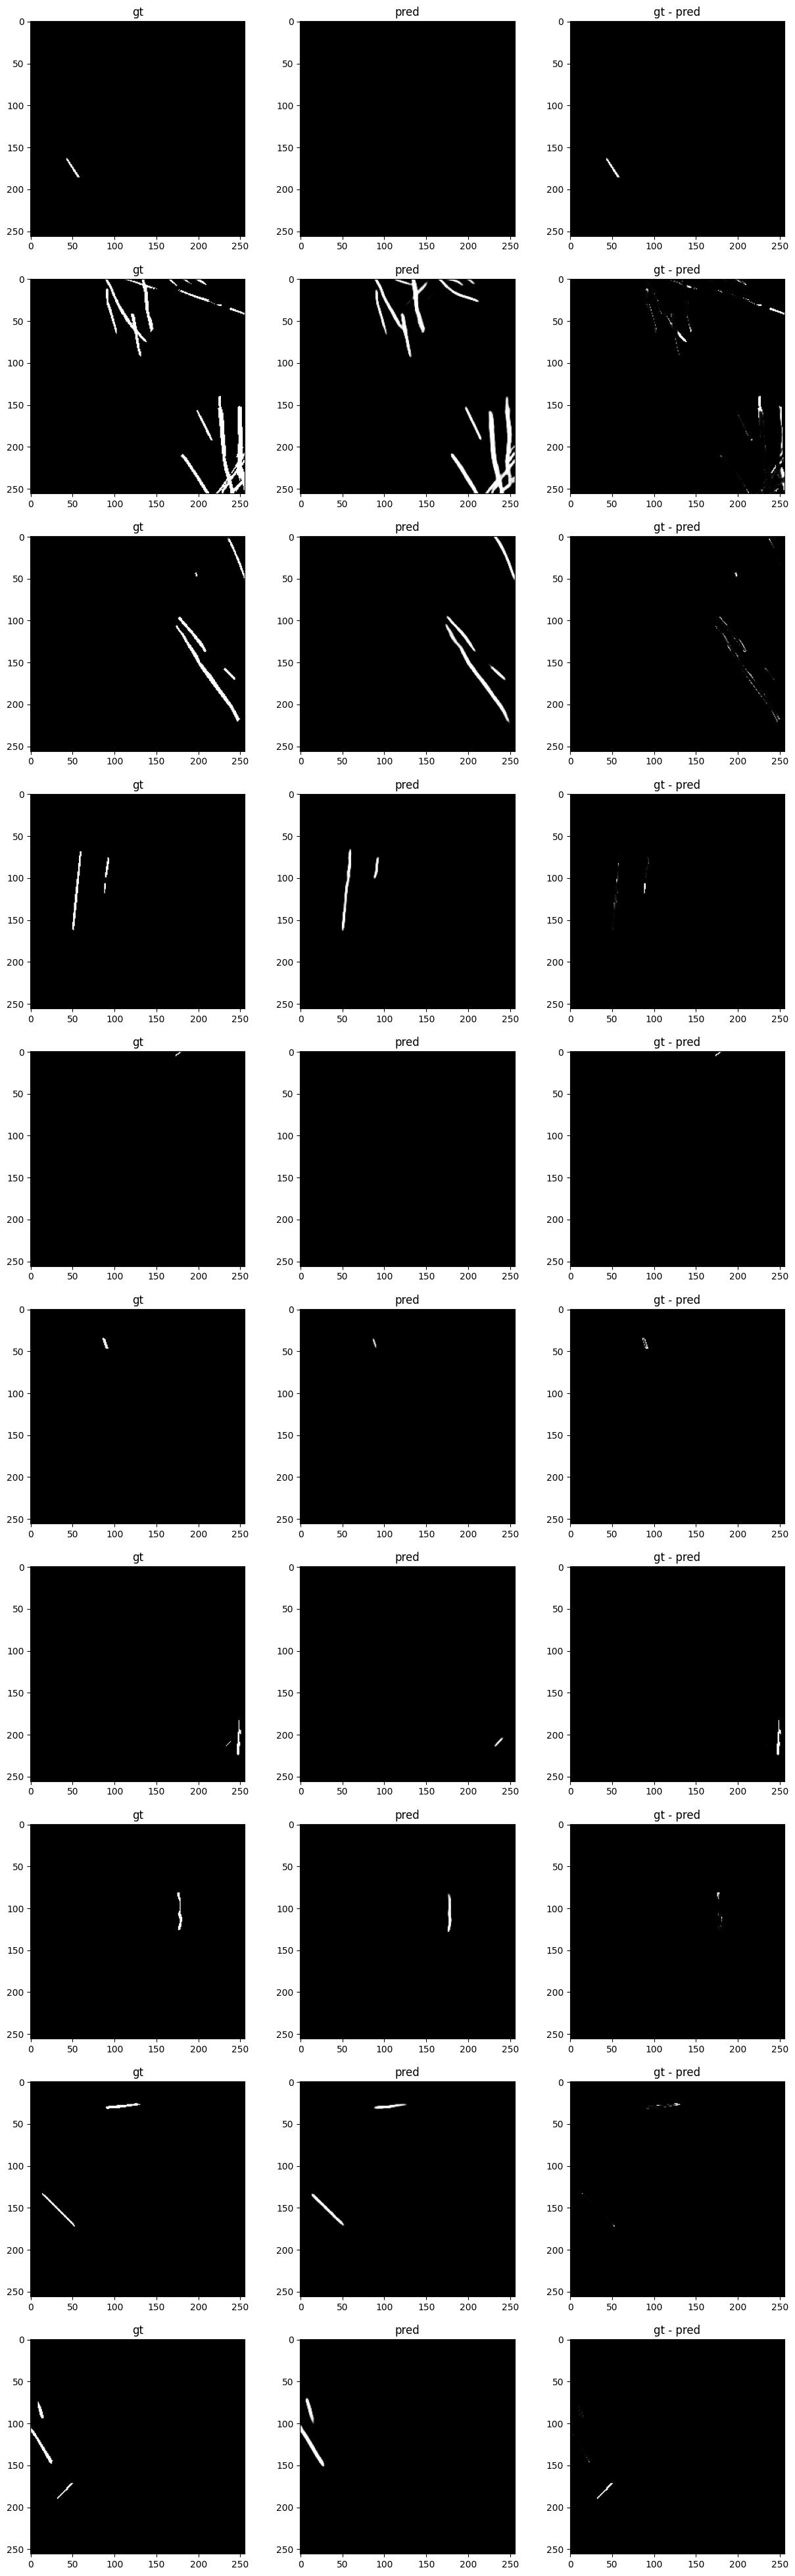

In [42]:
n = 10

indices = np.arange(len(preds))
with temp_seed(0):
    indices_to_show = np.random.choice(indices, size=n, replace=False)
print(indices_to_show)

fig, axes = plt.subplots(n, 3, figsize=(3 * 5, n * 5))
for i, axes_row in zip(indices_to_show, axes):
    axes_row[0].imshow(gts[i], vmin=0, vmax=1, cmap='gray')
    axes_row[0].set_title(f'gt')
    axes_row[1].imshow(preds[i], vmin=0, vmax=1, cmap='gray')
    axes_row[1].set_title(f'pred')
    axes_row[2].imshow(gts[i] - preds[i], vmin=0, vmax=1, cmap='gray')
    axes_row[2].set_title(f'gt - pred')

### Pseudolabels confidence

In [3]:
input_dir = Path('/workspace/data/pseudolabels/in-fold/images/')
threshold = 0.75

In [4]:
# Get grouped files
record_id_to_time_idx_to_files = defaultdict(lambda: defaultdict(list))
for file_path in input_dir.glob('*.png'):
    record_id = file_path.stem.split('_')[0]
    time_idx = int(file_path.stem.split('_')[1])
    record_id_to_time_idx_to_files[record_id][time_idx].append(file_path)

print(
    f'Found {len(record_id_to_time_idx_to_files)} records, '
    f'total {sum(len(time_idx_to_files) for time_idx_to_files in record_id_to_time_idx_to_files.values())} images'
)

Found 22385 records, total 179080 images


In [5]:
# Iterate over grouped files
confidences = []
for record_id, time_idx_to_files in tqdm(record_id_to_time_idx_to_files.items()):
    for time_idx, files in time_idx_to_files.items():
        preds_per_time_idx = []
        for file_path in files:
            pred = cv2.imread(str(file_path), cv2.IMREAD_GRAYSCALE)  # (H, W)
            preds_per_time_idx.append(pred)
        preds_per_time_idx = np.stack(preds_per_time_idx, axis=-1).astype(np.float32).mean(-1) / 255  # (H, W)
        pos_mask = preds_per_time_idx > threshold

        confidence1_map = np.where(
            pos_mask,
            (preds_per_time_idx - threshold) / (1 - threshold),
            (1 - preds_per_time_idx) / threshold,
        )
        confidence1 = confidence1_map.mean()
        
        confidence2_map = np.where(
            pos_mask,
            preds_per_time_idx,
            1 - preds_per_time_idx,
        )
        confidence2 = confidence2_map.mean()
        
        n_pos = pos_mask.sum()
        n_neg = (~pos_mask).sum()
        weights = np.ones_like(preds_per_time_idx)
        if n_neg > 0 and n_pos > 0:
            weights[pos_mask] = n_neg / (n_pos + n_neg)
            weights[~pos_mask] = n_pos / (n_pos + n_neg)
        confidence3 = (confidence1_map * weights).sum() / weights.sum()
        confidence4 = (confidence2_map * weights).sum() / weights.sum()

        confidences.append(
            {
                'record_id': record_id,
                'time_idx': time_idx,
                'confidence1': confidence1,
                'confidence2': confidence2,
                'confidence3': confidence3,
                'confidence4': confidence4,
            }
        )

  0%|          | 0/22385 [00:00<?, ?it/s]

100%|██████████| 22385/22385 [19:55<00:00, 18.73it/s]


In [7]:
df = pd.DataFrame(confidences)
df.head()

,record_id,time_idx,confidence1,confidence2,confidence3,confidence4
0,6965732033396889226,1,1.333333,1.0,1.333333,1.0
1,6965732033396889226,7,1.333333,1.0,1.333333,1.0
2,6965732033396889226,3,1.333333,1.0,1.333333,1.0
3,6965732033396889226,2,1.333333,1.0,1.333333,1.0
4,6965732033396889226,5,1.333333,1.0,1.333333,1.0


(array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.04954311,  0.20237099,  0.19607314,  0.2

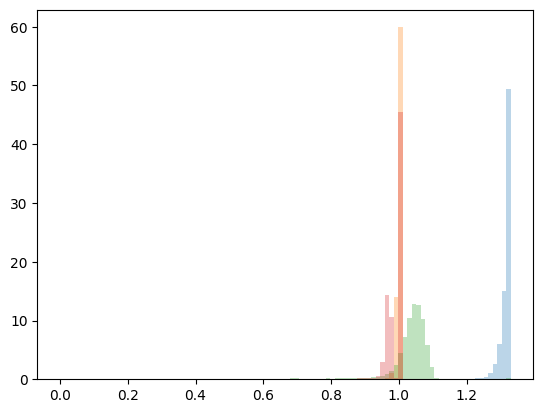

In [10]:
plt.hist(df['confidence1'], bins=100, density=True, range=(0, 1.33), alpha=0.3, label='confidence1')
plt.hist(df['confidence2'], bins=100, density=True, range=(0, 1.33), alpha=0.3, label='confidence1')
plt.hist(df['confidence3'], bins=100, density=True, range=(0, 1.33), alpha=0.3, label='confidence1')
plt.hist(df['confidence4'], bins=100, density=True, range=(0, 1.33), alpha=0.3, label='confidence1')